<a href="https://colab.research.google.com/github/Seolang/stikyAI/blob/main/main/CNN/CNN_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
#drive.mount('/content/drive')

In [50]:
# one-hot encoder

import numpy as np
from collections import defaultdict

def encode_one_hot(train_set, classes="AGCT"):
    encoder = defaultdict(lambda: np.array([0]*len(classes)))
    pad = 9
        
    for i, _class in enumerate(classes):
        tmp = np.zeros(len(classes))
        tmp[i] = 1
        encoder[_class] = tmp
        
    output = []
    for record in train_set:
        encoded_record = []
        
    output = []
    for record in tqdm(train_set):
        encoded_record = []
        for i in range(pad):
            encoded_record.append([.25, .25, .25, .25])
        for c in record.upper():
            encoded_record.append(encoder[c])
        for i in range(pad):
            encoded_record.append([.25, .25, .25, .25])
            
        output.append(encoded_record)
        
    output = np.array(output)
    
    return output

In [51]:
# Parsing
import gzip
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from google.colab import files
#myfile = files.upload()
# single dataset version
def get_dataset(path):
    
    dataset =  gzip.open(path, "r")
    output = []    
    for i, record in tqdm(enumerate(dataset)):
        record = record.decode()
        record = record[:-1]
        record = record.split('\t')
        if i != 0:
            output.append(record)
    output = np.array(output).reshape([-1, 4])
    
    return encode_one_hot(output[:, 2]), np.array([int(i) for i in output[:, 3]]).flatten()

x, y = get_dataset("/content/Alx1_DBD_TAAAGC20NCG_3_Z_B.seq.gz")
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size = 0.33, random_state=112)

del(x, y)

print(train_x.shape)
print(train_y.shape)

print(valid_x.shape)
print(valid_y.shape)

255509it [00:01, 235262.37it/s]
100%|██████████| 255508/255508 [00:07<00:00, 33515.16it/s]


(171190, 38, 4)
(171190,)
(84318, 38, 4)
(84318,)


In [52]:
# train
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Conv1D, ReLU, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K

K.clear_session()
epoch = 10
l2_rate = 1e-5
lr = 0.001
batch_size = 32

model = Sequential()

model.add(Conv1D(input_shape=train_x.shape[1:], 
                 filters=16, kernel_size=10, strides=1, 
                 kernel_regularizer=regularizers.l2(l2_rate)))

model.add(ReLU())
model.add(MaxPooling1D(pool_size=29))
model.add(Flatten())

model.add(Dense(32, kernel_regularizer=regularizers.l2(l2_rate)))
model.add(ReLU())
model.add(Dropout(rate=0.3))
model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(l2_rate)))

adam = Adam(lr=lr)
model.compile(loss='mse', optimizer=adam, metrics=[AUC(),'accuracy'])
model.summary()

history = model.fit(train_x, train_y, 
                    validation_data=(valid_x, valid_y), 
                    batch_size=batch_size, epochs=epoch, shuffle=True, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 16)            656       
_________________________________________________________________
re_lu (ReLU)                 (None, 29, 16)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
5350/5350 [==============================] - 19s 3ms/step - loss: 0.0871 - auc: 0.9489 - accuracy: 0.8834 - val_loss: 0.0750 - val_auc: 0.9624 - val_accuracy: 0.8974
Epoch 2/10
5350/5350 [==============================] - 19s 4ms/step - loss: 0.0752 - auc: 0.9611 - accuracy: 0.8981 - val_loss: 0.0746 - val_auc: 0.9641 - val_accuracy: 0.8976
Epoch 3/10
5350/5350 [==============================] - 17s 3ms/step - loss: 0.0733 - auc: 0.9632 - accuracy: 0.9002 - val_loss: 0.0723 - val_auc: 0.9655 - val_accuracy: 0.9015
Epoch 4/10
5350/5350 [==============================] - 19s 4ms/step - loss: 0.0723 - auc: 0.9641 - accuracy: 0.9019 - val_loss: 0.0731 - val_auc: 0.9657 - val_accuracy: 0.9000
Epoch 5/10
5350/5350 [==============================] - 17s 3ms/step - loss: 0.0715 - auc: 0.9647 - accuracy: 0.9034 - val_loss: 0.0731 - val_auc: 0.9658 - val_accuracy: 0.9001
Epoch 6/10
5350/5350 [==============================] - 19s 3ms/step - loss: 0.0713 - auc: 0.9649 - accuracy: 0.903

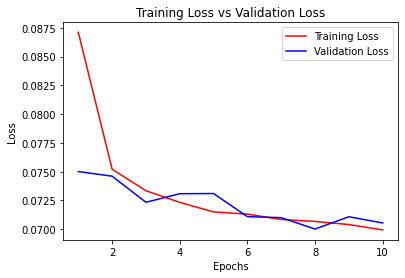

In [53]:
# graph
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
model.save("./Deepbind.h5")